# Supervised Learning Classification Project: AllLife Bank Personal Loan Campaign

## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [170]:
%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# To build model for prediction

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Loading the dataset

In [171]:
loan_df = pd.read_csv("Loan_Modeling.csv")

<IPython.core.display.Javascript object>

## Data Overview

* Observations
* Sanity checks

### View the first and last 5 rows of the dataset.

In [172]:
loan_df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [173]:
loan_df.tail()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.8,1,0,0,0,0,1,1


<IPython.core.display.Javascript object>

### Understand the shape of the dataset.

In [174]:
loan_df.shape

(5000, 14)

<IPython.core.display.Javascript object>

### Check the data types of the columns for the dataset.

In [175]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


<IPython.core.display.Javascript object>

In [176]:
loan_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


<IPython.core.display.Javascript object>

In [177]:
# checking for unique values in ID column
loan_df["ID"].nunique()

5000

<IPython.core.display.Javascript object>

* Since all the values in ID column are unique we can drop it

In [178]:
loan_df.drop(["ID"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Check for missing values

In [179]:
loan_df.isnull().sum()

Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

<IPython.core.display.Javascript object>

* There are no missing values in the dataset

#### Observations:
- Upon looking at the head and tail of the dataset, it appears our data was indeed loaded correctly
- Looking at the shape with `loan_df.shape`, we can see we the dataset has 5000 rows and 14 columns
- By using `loan_df.info()`, we can see the data has 2 different datatypes:
    - 1 columns of type float64, which is a 64-bit floating point number
        - CCAvg
    - 13 columns of type int64, which is a 64-bit integer
        - ID, Age, Experience, Income, ZIPCode, Family, Education, Mortgage, Personal_Loan, Securities_Account, CDAccount, Online, CreditCard
- Looking at the statistical summary with `loan_df.describe().T` reveals some interesting things to note, such as Experience having a min value of -3. 
- Each ID is unique, there are no duplicate entries and there are no missing values in the dataset



## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

### Checking for Anomalous Values

In [180]:
# Map the values to 1: Undergrad; 2: Graduate 3: Advanced/Professional
loan_df["Education"].replace(1, "Undergraduate", inplace=True)
loan_df["Education"].replace(2, "Graduate", inplace=True)
loan_df["Education"].replace(3, "Advanced/Professional", inplace=True)

<IPython.core.display.Javascript object>

* Treating the negative values of Experience: We assume that these negative signs here are data input errors, so we will replace them with positive signs

In [181]:
# checking if experience <0
loan_df[loan_df["Experience"] < 0]["Experience"].unique()

array([-1, -2, -3], dtype=int64)

<IPython.core.display.Javascript object>

In [182]:
# Correcting the experience values
loan_df["Experience"].replace(-1, 1, inplace=True)
loan_df["Experience"].replace(-2, 2, inplace=True)
loan_df["Experience"].replace(-3, 3, inplace=True)

<IPython.core.display.Javascript object>

### Feature Engineering

In [183]:
# checking the number of uniques in the zip code
loan_df["ZIPCode"].nunique()

467

<IPython.core.display.Javascript object>

In [184]:
loan_df["ZIPCode"] = loan_df["ZIPCode"].astype(str)
print(
    "Number of unique values if we take first two digits of ZIPCode: ",
    loan_df["ZIPCode"].str[0:2].nunique(),
)
loan_df["ZIPCode"] = loan_df["ZIPCode"].str[0:2]

loan_df["ZIPCode"] = loan_df["ZIPCode"].astype("category")

Number of unique values if we take first two digits of ZIPCode:  7


<IPython.core.display.Javascript object>

In [185]:
## Converting the data type of categorical features to 'category'
cat_cols = [
    "Education",
    "Personal_Loan",
    "Securities_Account",
    "CD_Account",
    "Online",
    "CreditCard",
    "ZIPCode",
]
loan_df[cat_cols] = loan_df[cat_cols].astype("category")

<IPython.core.display.Javascript object>

## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Univariate Analysis

In [186]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

In [187]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

#### Age

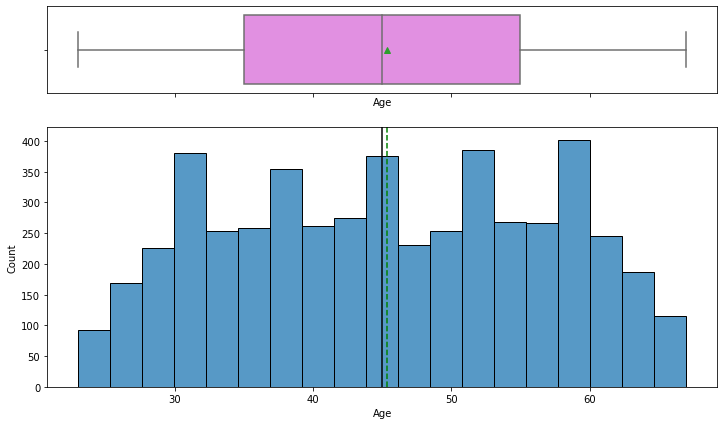

<IPython.core.display.Javascript object>

In [188]:
histogram_boxplot(loan_df, "Age")

##### Observations
- Minimum Age: 23
- Maximum Age: 67
- Average Age: 45
- There are no outliers in the data

#### Experience

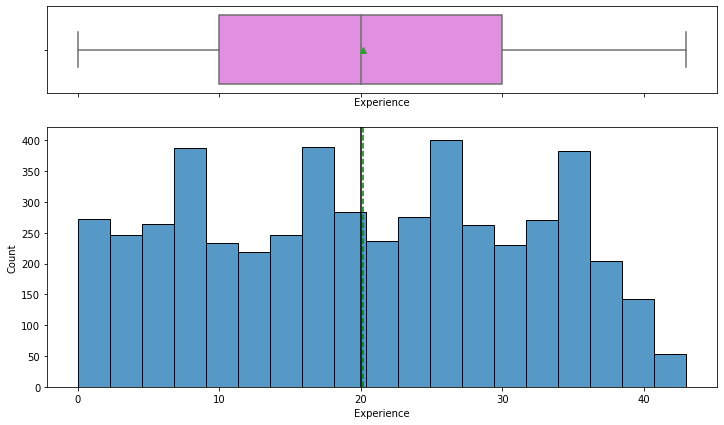

<IPython.core.display.Javascript object>

In [189]:
histogram_boxplot(loan_df, "Experience") 

##### Observations:
- Minimum Years of Experience: 0 years
- Maximum Years of Experience: 43 years
- Average Years of Experience: About 20 years
- There are no outliers in the data

#### Income

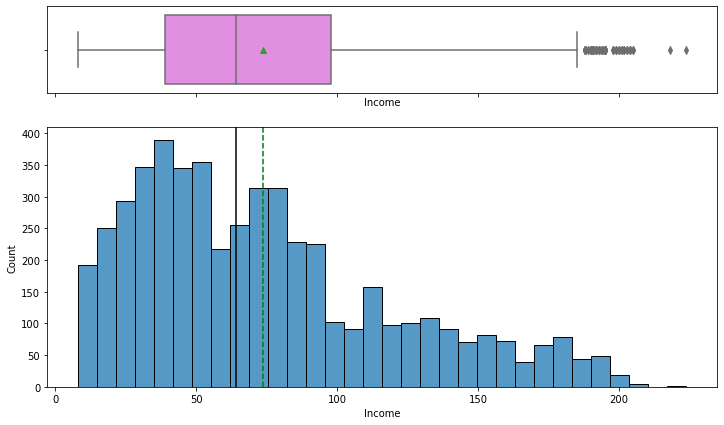

<IPython.core.display.Javascript object>

In [190]:
histogram_boxplot(loan_df, "Income") 

##### Observations:
- Minimum Income: $8k
- Maximum Income: $224k
- Average Income: $64k 
- Dataset is right skewed
- There are outliers in the data, however it appears they are consistent with the rest of the data so no action is required to treat these outliers

#### CCAvg

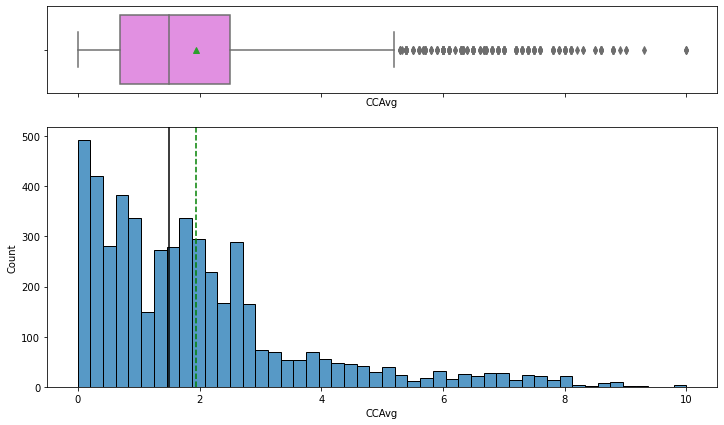

<IPython.core.display.Javascript object>

In [191]:
histogram_boxplot(loan_df, "CCAvg") 

##### Observations:
- Minimum: $0k 
- Maximum: $10k 
- Average: About $1.9k
- Dataset is skewed to the right
- There are outliers in the data, however it appears they are consistent with the rest of the data so no action is required to treat these outliers

#### Mortgage

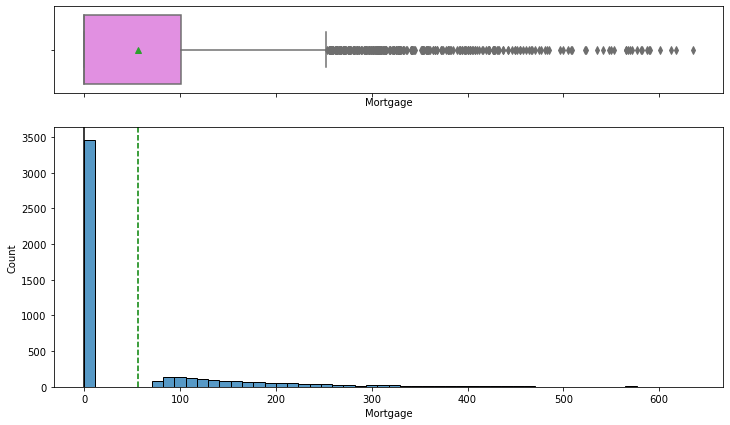

<IPython.core.display.Javascript object>

In [192]:
histogram_boxplot(loan_df, "Mortgage") 

Let's get a better view of mortgage > $0k:

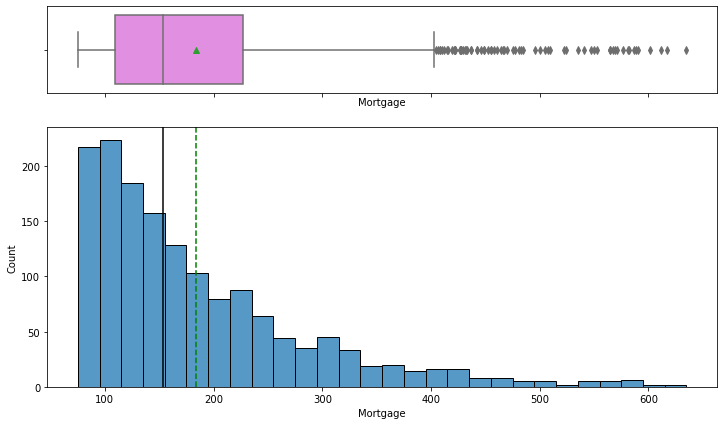

<IPython.core.display.Javascript object>

In [193]:
mortgage_gt_zero = loan_df[loan_df['Mortgage'] > 0]
histogram_boxplot(mortgage_gt_zero, "Mortgage")

##### Observations
- Minimum: $0k 
- Maximum: $635k
- Average: About $56.5k
- Dataset is skewed to the right
- There are outliers in the data, however it appears they are consistent with the rest of the data so no action is required to treat these outliers

#### Family 

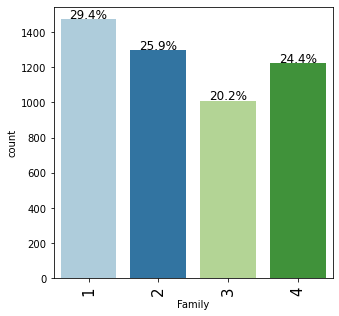

<IPython.core.display.Javascript object>

In [194]:
labeled_barplot(loan_df, "Family", perc=True) 

##### Observations:
The majority of families are of size 1 (29.4%), followed by families of size 2 (25.9%). Third is families of size 4 (24.4%), and the minority is families of size 3 (20.2%).

#### Education

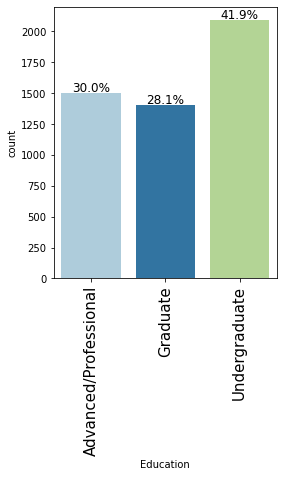

<IPython.core.display.Javascript object>

In [195]:
labeled_barplot(loan_df, "Education", perc=True) 

##### Observations:
- 41.9% of customers: Undergraduate 
- 30.0% of customers: Advanced/Professional
- 28.1% of customers: Graduate

#### Securities_Account

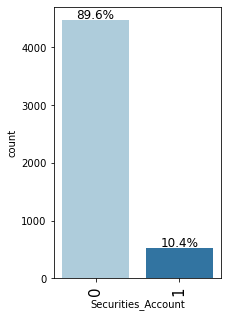

<IPython.core.display.Javascript object>

In [196]:
labeled_barplot(loan_df, "Securities_Account", perc=True) 

##### Observations:
89.6% of customers do not have securities accounts with the bank, and 10.4% of customers do have securities accounts with the bank.

#### CD_Account

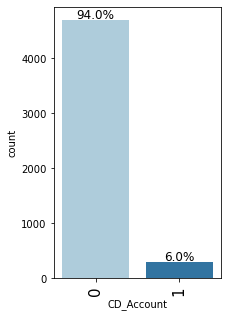

<IPython.core.display.Javascript object>

In [197]:
labeled_barplot(loan_df, "CD_Account", perc=True) 

##### Observations:
94.0% of customers do not have a CD account with the bank, while 6% of customers do have a CD account with the bank. 

#### Online

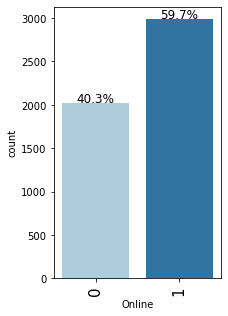

<IPython.core.display.Javascript object>

In [198]:
labeled_barplot(loan_df, "Online", perc=True) 

##### Observations:
59.7% of customers use internet banking facilities, while 40.3% of customers do not. 

#### CreditCard

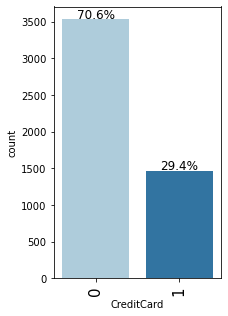

<IPython.core.display.Javascript object>

In [199]:
labeled_barplot(loan_df, "CreditCard", perc=True) 

##### Observations:
70.6% of customers do not use a credit card issued by another bank, while 29.4% of customers do use a credit issued by another bank. 

#### ZIPCode

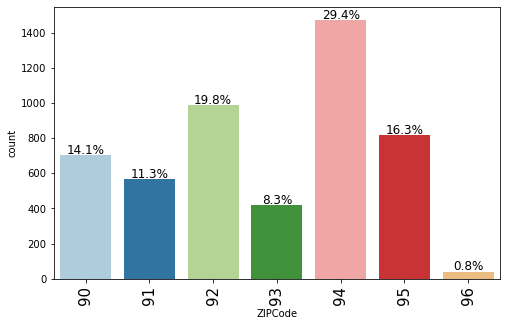

<IPython.core.display.Javascript object>

In [200]:
labeled_barplot(loan_df, "ZIPCode", perc=True) 

##### Observations:
- 29.4% of customers reside in the zip code beginning in 94
- 19.8% of customers reside in the zip code beginning in 92
- 16.3% of customers reside in the zip code beginning in 95
- 14.1% of customers reside in the zip code beginning in 90
- 11.3% of customers reside in the zip code beginning in 91
- 8.3% of customers reside in the zip code beginning in 93
- 0.8% of customers reside in the zip code beginning in 96

### Bivariate Analysis

In [201]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

In [202]:
### function to plot distributions wrt target

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

#### Correlation check

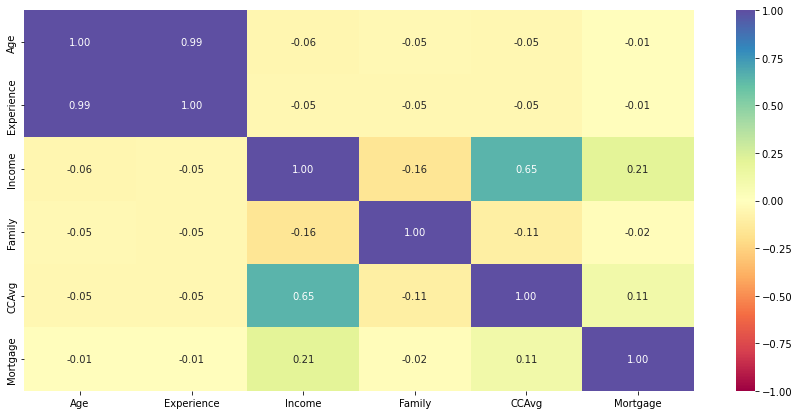

<IPython.core.display.Javascript object>

In [228]:
plt.figure(figsize=(15, 7))
sns.heatmap(loan_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral") 
plt.show()

#### Age vs Personal_Loan

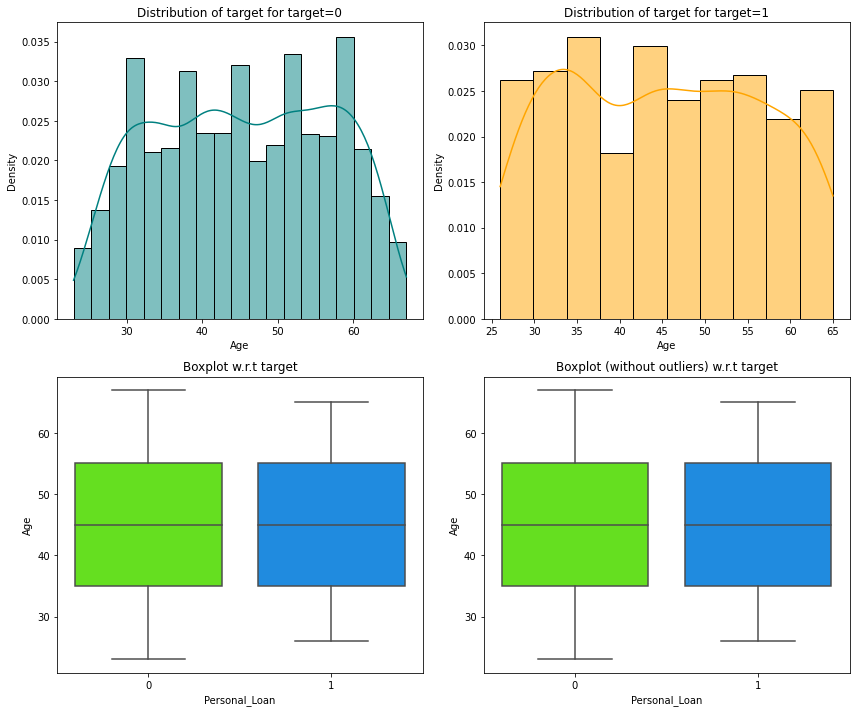

<IPython.core.display.Javascript object>

In [235]:
distribution_plot_wrt_target(loan_df, "Age", "Personal_Loan")

##### Observations:
It appears Age does not have a relationship with Personal_Loan

#### Experience vs Personal_Loan

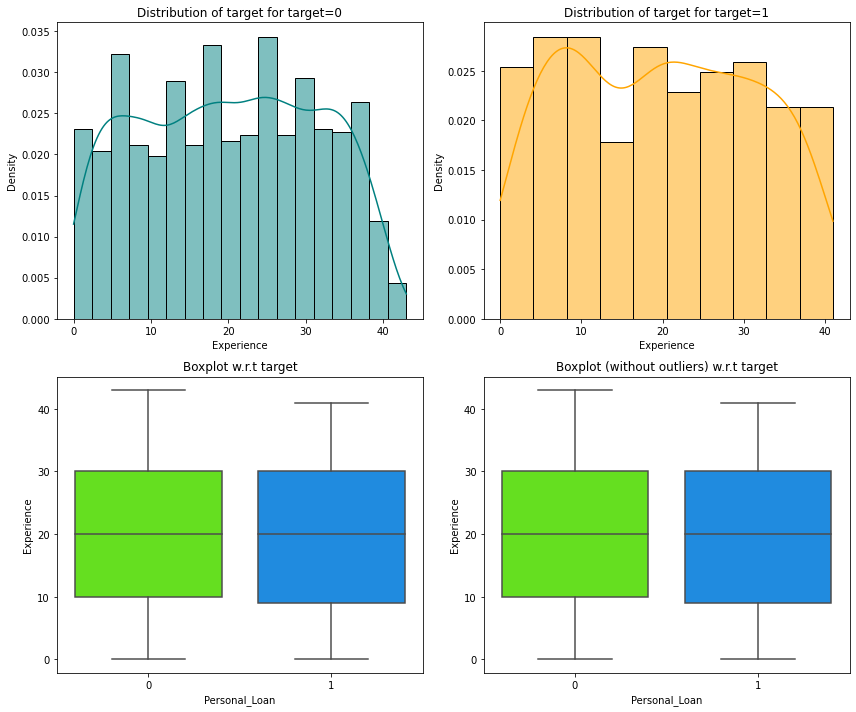

<IPython.core.display.Javascript object>

In [236]:
distribution_plot_wrt_target(loan_df, "Experience", "Personal_Loan")

##### Observations:
It appears Experience does not have a relationship with Personal_Loan

#### Income vs Personal_Loan

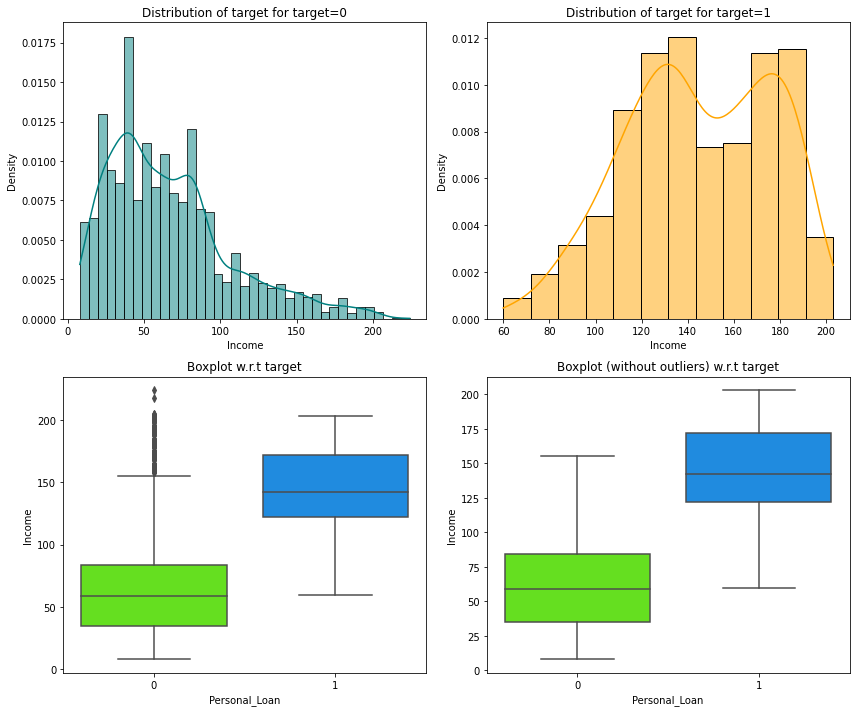

<IPython.core.display.Javascript object>

In [237]:
distribution_plot_wrt_target(loan_df, "Income", "Personal_Loan")

##### Observations:
- The mean income for customers who did not accept a personal loan is about $65k
- The mean income for customers who did accept a personal loan is about $145k
- Based on the graphs, it appears there is a relationship between Income and Personal_Loan. We can observe that the higher the income, the more likely the customer will accept a personal loan. 

#### Personal_Loan vs ZIPCode

ZIPCode         90   91   92   93    94   95  96   All
Personal_Loan                                         
All            703  565  988  417  1472  815  40  5000
0              636  510  894  374  1334  735  37  4520
1               67   55   94   43   138   80   3   480
------------------------------------------------------------------------------------------------------------------------


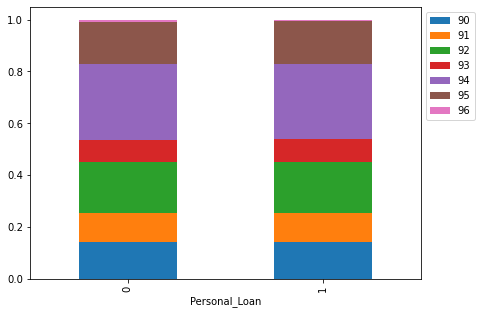

<IPython.core.display.Javascript object>

In [ ]:
stacked_barplot(loan_df, "Personal_Loan", "ZIPCode")  

#### Family vs Personal_Loan

Personal_Loan     0    1   All
Family                        
All            4520  480  5000
4              1088  134  1222
3               877  133  1010
1              1365  107  1472
2              1190  106  1296
------------------------------------------------------------------------------------------------------------------------


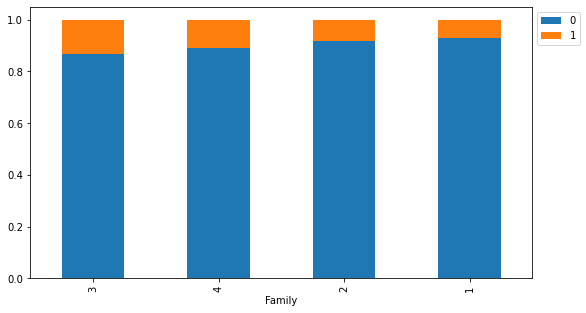

<IPython.core.display.Javascript object>

In [ ]:
stacked_barplot(loan_df, "Family", "Personal_Loan")  

##### Observations:
Based on the graphs, it appears that families of size 3 or 4 are more likely to accept a personal loan. This could show a trend that as family size grows, customers are more likely to accept personal loan. 

#### CCAvg vs Personal_Loan

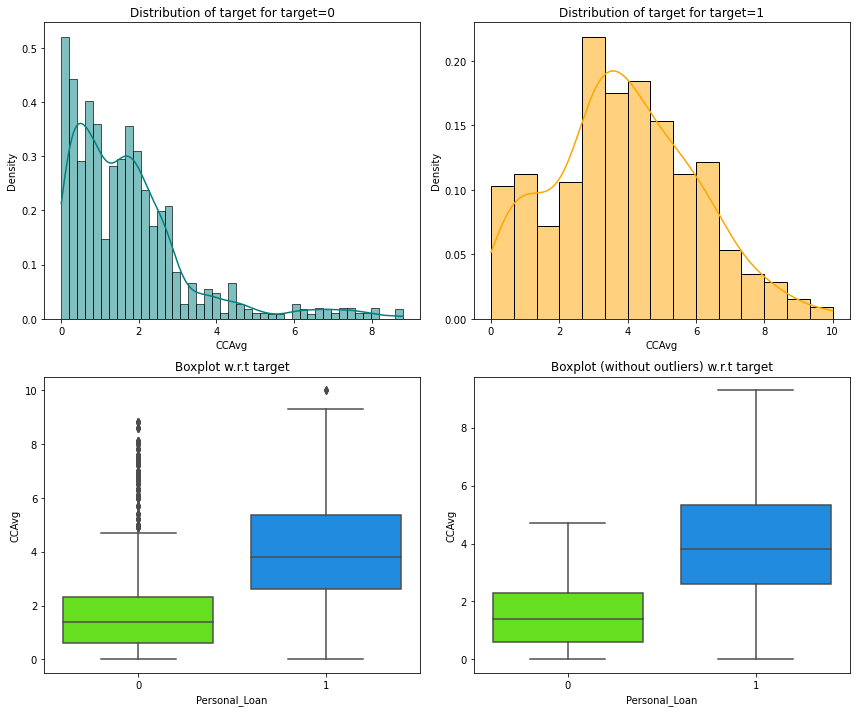

<IPython.core.display.Javascript object>

In [ ]:
distribution_plot_wrt_target(loan_df, "CCAvg", "Personal_Loan")

##### Observations:
- 

#### Education vs Personal_Loan

Personal_Loan             0    1   All
Education                             
All                    4520  480  5000
Advanced/Professional  1296  205  1501
Graduate               1221  182  1403
Undergraduate          2003   93  2096
------------------------------------------------------------------------------------------------------------------------


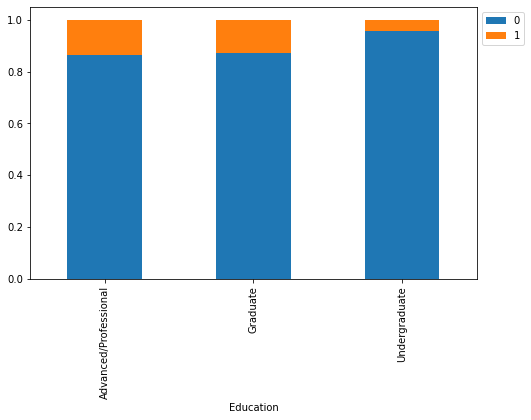

<IPython.core.display.Javascript object>

In [ ]:
stacked_barplot(loan_df, "Education", "Personal_Loan")

##### Observations:
- Fewer Undergraduate customers have accepted a personal loan offered in the last campaign, compared to customers with a Graduate or Advanced/Professional education
- There doesn't seem to be a significant difference between customers with Advanced/Professional and Graduate level education with regards to accepting the personal loan offered in the last campaign. 
- It seems customers with Advanced/Professional and Graducate level educations are more willing to accept a personal loan than those with an Undergraduate education. 

#### Mortgage vs Personal_Loan

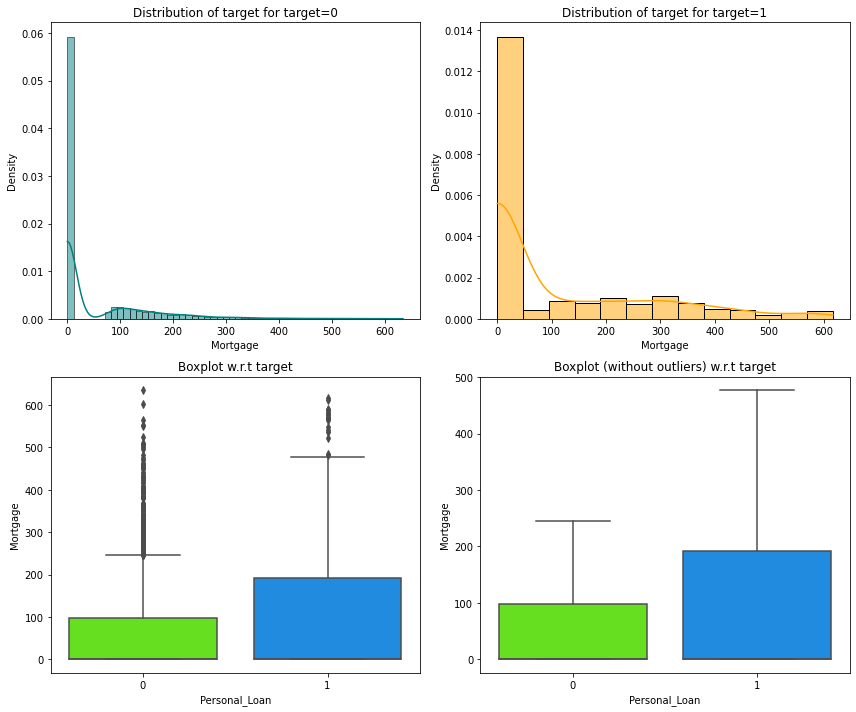

<IPython.core.display.Javascript object>

In [238]:
distribution_plot_wrt_target(loan_df, "Mortgage", "Personal_Loan")

Due to the high number of customers not paying a mortgage, the distribution looks to be heavily skewed to the right. To get a better look, let us create a new plot that does not include the customers paying no mortgage:

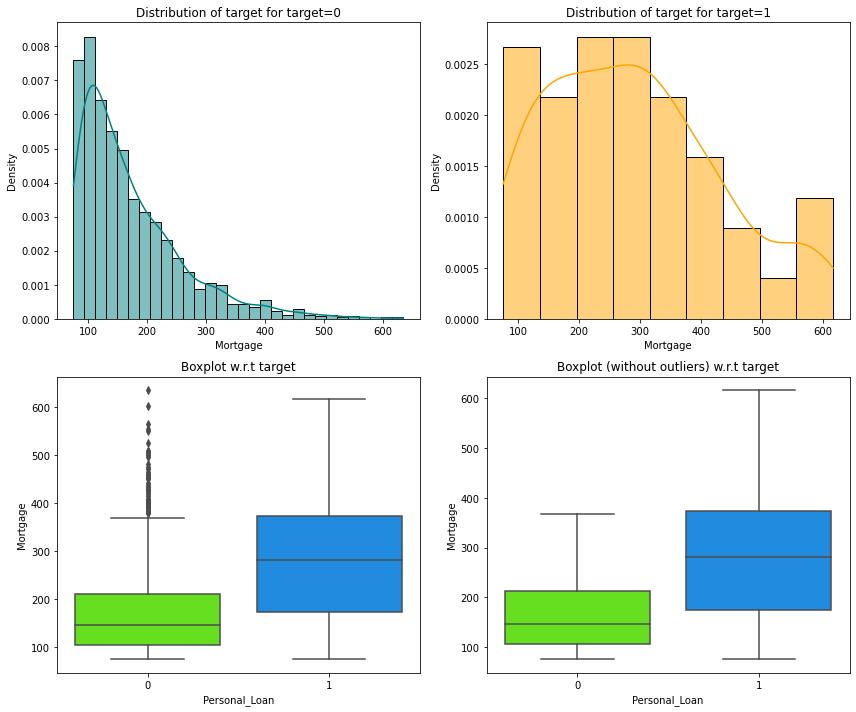

<IPython.core.display.Javascript object>

In [239]:
distribution_plot_wrt_target(mortgage_gt_zero, "Mortgage", "Personal_Loan")

##### Observations:
- The mean value of mortgage paid by customers not accepting a personal loan is about $150k
- The mean value of mortgage paid by customers paying a personal loan is about $290k
- Based on this data, it appears that as the mortgage value increases, the more likely the customer is to accept a personal loan

#### Securities_Account vs Personal_Loan

Securities_Account     0    1   All
Personal_Loan                      
All                 4478  522  5000
0                   4058  462  4520
1                    420   60   480
------------------------------------------------------------------------------------------------------------------------


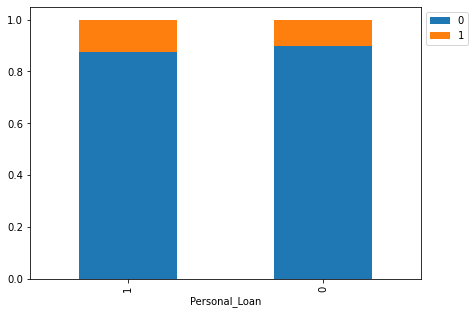

<IPython.core.display.Javascript object>

In [206]:
stacked_barplot(loan_df, "Personal_Loan", "Securities_Account")  

#### CD_Account vs Personal_Loan

CD_Account        0    1   All
Personal_Loan                 
All            4698  302  5000
0              4358  162  4520
1               340  140   480
------------------------------------------------------------------------------------------------------------------------


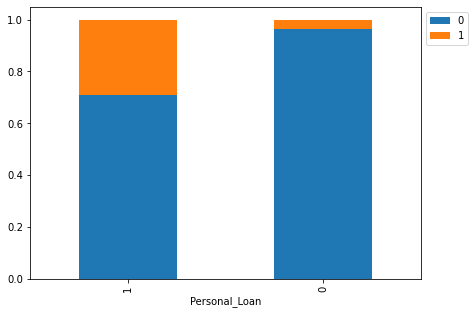

<IPython.core.display.Javascript object>

In [207]:
stacked_barplot(loan_df, "Personal_Loan", "CD_Account")  

#### Online vs Personal_Loan

Online            0     1   All
Personal_Loan                  
All            2016  2984  5000
0              1827  2693  4520
1               189   291   480
------------------------------------------------------------------------------------------------------------------------


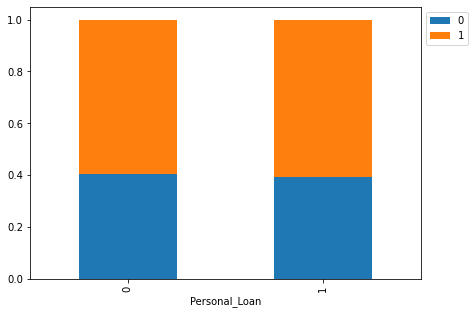

<IPython.core.display.Javascript object>

In [208]:
stacked_barplot(loan_df, "Personal_Loan", "Online")  

#### CreditCard vs Personal_Loan

CreditCard        0     1   All
Personal_Loan                  
All            3530  1470  5000
0              3193  1327  4520
1               337   143   480
------------------------------------------------------------------------------------------------------------------------


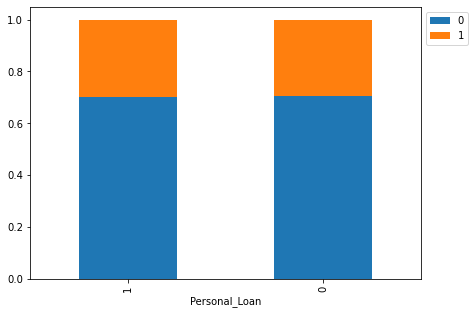

<IPython.core.display.Javascript object>

In [209]:
stacked_barplot(loan_df, "Personal_Loan", "CreditCard")  

**Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
2. How many customers have credit cards?
3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
4. How does a customer's interest in purchasing a loan vary with their age?
5. How does a customer's interest in purchasing a loan vary with their education?

### **Question 1:** What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?


count    5000.000000
mean       56.498800
std       101.713802
min         0.000000
25%         0.000000
50%         0.000000
75%       101.000000
max       635.000000
Name: Mortgage, dtype: float64


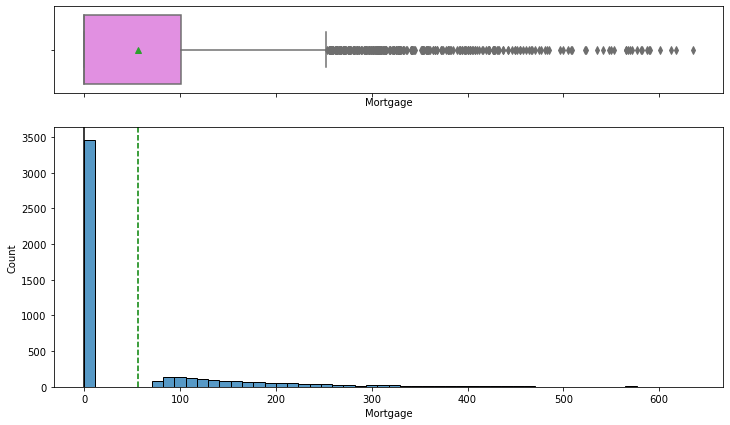

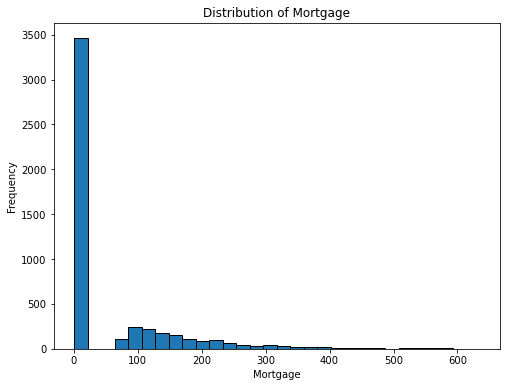

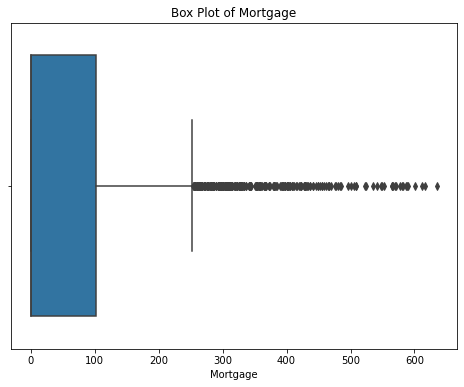

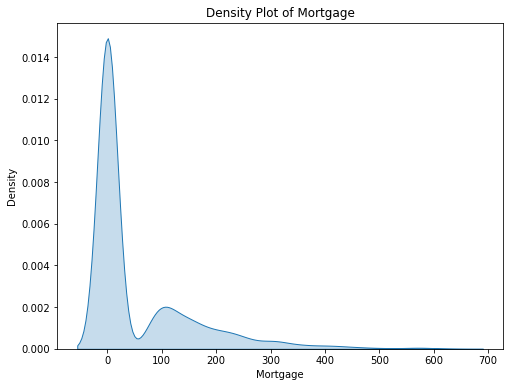

<IPython.core.display.Javascript object>

In [215]:
print(loan_df['Mortgage'].describe())
histogram_boxplot(loan_df, "Mortgage") 

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(loan_df['Mortgage'], bins=30, edgecolor='k')
plt.xlabel('Mortgage')
plt.ylabel('Frequency')
plt.title('Distribution of Mortgage')
plt.show()

# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=loan_df, x='Mortgage')
plt.xlabel('Mortgage')
plt.title('Box Plot of Mortgage')
plt.show()

# Density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=loan_df, x='Mortgage', fill=True)
plt.xlabel('Mortgage')
plt.ylabel('Density')
plt.title('Density Plot of Mortgage')
plt.show()

### Data Preparation for Modeling

In [216]:
# Separate independent and dependent variable
X = loan_df.drop(["Personal_Loan", "Experience"], axis=1)
Y = loan_df["Personal_Loan"]

<IPython.core.display.Javascript object>

In [217]:
# Complete the code to apply dummies on ZIPCode and Education
X = pd.get_dummies(X, columns=["ZIPCode", "Education"], drop_first=True)  

# Complete the code to split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

<IPython.core.display.Javascript object>

In [218]:
print("Shape of Training set : ", X_train.shape)     
print("Shape of test set : ", X_test.shape)          
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))              
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))           

Shape of Training set :  (3500, 17)
Shape of test set :  (1500, 17)
Percentage of classes in training set:
0    0.905429
1    0.094571
Name: Personal_Loan, dtype: float64
Percentage of classes in test set:
0    0.900667
1    0.099333
Name: Personal_Loan, dtype: float64


<IPython.core.display.Javascript object>

## Model Building

### Model Evaluation Criterion

**Model can make wrong predictions as:**

1. Predicting a customer will take the personal loan but in reality the customer will not take the personal loan - Loss of resources
2. Predicting a customer will not take the personal loan but in reality the customer was going to take the personal loan - Loss of opportunity

**Which case is more important?**
* Losing a potential customer by predicting that the customer will not be taking the personal loan but in reality the customer was going to take the personal loan.

**How to reduce this loss i.e need to reduce False Negatives?**

* Bank would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false negatives. Hence, the focus should be on increasing Recall or minimizing the false negatives.

### Model Building: Logistic Regression

First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_sklearn_with_threshold function will be used to check the model performance of models. 
* The confusion_matrix_sklearn_with_threshold function will be used to plot confusion matrix.

In [219]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn_with_threshold(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [220]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Model Performance Improvement: Logistic Regression

### Model Building: Decision Tree

### Model Performance Improvement: Decision Tree

## Model Comparison and Final Model Selection

## Actionable Insights and Business Recommendations


* What recommedations would you suggest to the bank?

___